# SIREN

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.model import SIREN
from src.laplacian import sdfGradient, gridLaplacian, gridLaplaceBeltrami, gridDx, gridDy, gridDxMasked, gridDyMasked
from scipy import sparse
from scipy.ndimage import gaussian_filter
from src.diff_operators import gradient, divergence

In [3]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    #hessians = np.zeros( (amount_samples, 2, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        #hessians[head:min(head + max_batch, amount_samples)] = jacobian( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians

In [4]:
model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

SIREN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (6): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [5]:
N = 256
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

In [6]:
fX, dfX, LfX = evaluate(  model, X, device=device )
LfX = np.clip( LfX, np.percentile(LfX, 0.1), np.percentile(LfX, 99.9))
u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[ np.abs(fX).flatten() < 1e-3] )[3] )
#u0 = gaussian_filter( np.eye( 1,N**2, k=( np.arange(0, N**2)[fX.flatten() < 1e-8] )[100] ).reshape((N,N)), 1.5 ).flatten()

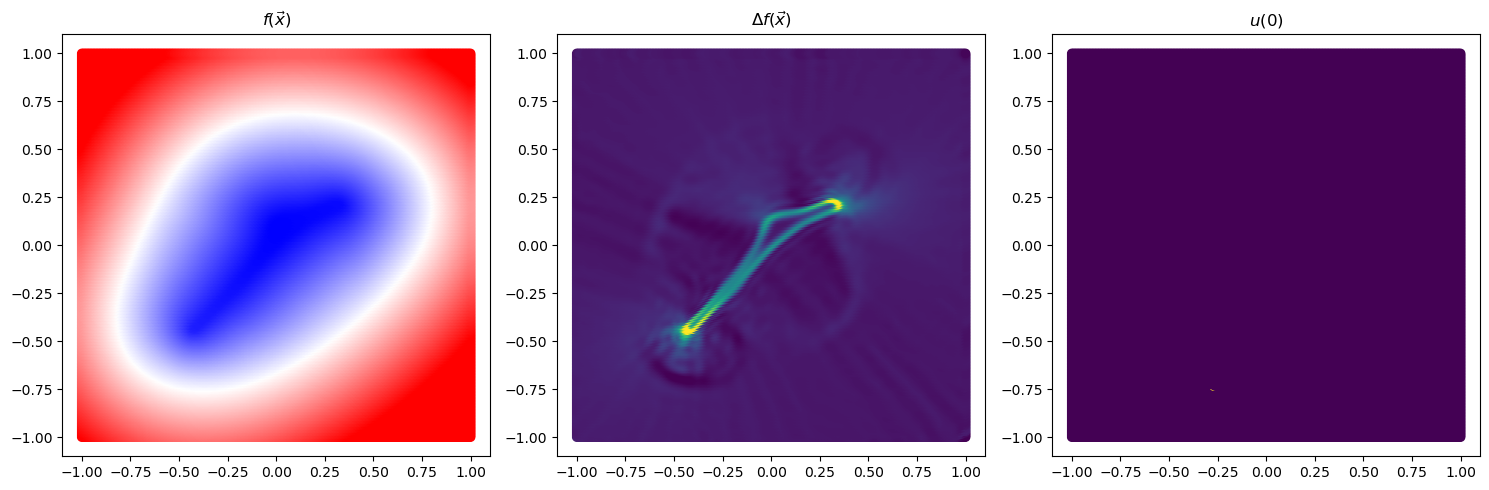

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
clip_val = min( np.abs(np.min(fX)), np.abs(np.max(fX)) )
axs[0].scatter(X[:,0], X[:,1], c=fX, cmap='bwr', vmin=-clip_val, vmax= clip_val)
axs[1].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[2].scatter(X[:,0], X[:,1], c=u0, cmap='viridis')

axs[0].set_title(r'$f(\vec{x})$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$u(0)$')

plt.tight_layout()
plt.show()

In [8]:
#L = sdfLaplacian( N ,X,fX, dfX, LfX)
#L = gridLaplacianOld(N)
#
mask = np.abs(fX).flatten() < 0.07
L= gridLaplacian(N, mask)
#G = gridGradProyection( N, dfX, LfX, mask)

In [9]:
h = 2 / (N-1)
t = h ** 2 
#t = 1e-5

I = sparse.csr_matrix( (N**2, N**2) )
I.setdiag( np.ones(N ** 2), k=0 )
ut = sparse.linalg.spsolve( (I - t * ( L )), u0.flatten() )
#ut = sparse.linalg.spsolve( (I - t * ( L)), ut.flatten() )
#ut = sparse.linalg.spsolve( (I - t * ( L)), ut.flatten() )
#ut = sparse.linalg.spsolve( (I - t * ( L)), ut.flatten() )

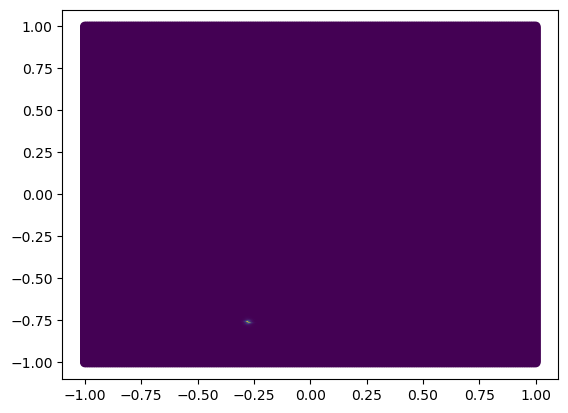

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=ut, vmin=0,vmax= np.max(ut), cmap='viridis')

$$P_{\nabla \psi} \nabla u = \nabla u - (\nabla u \cdot \nabla \psi) \nabla \psi$$

Entonces:
```python
[ (Gx - dfX[:,0] @ (Dpsix @ Gx + Dpsiy @ Gy) ) @ u, (Gy - dfX[:,1] @ (Dpsix @ Gx + Dpsiy @ Gy) ) @ u ]
```


In [11]:
Gx, Gy = sdfGradient( N, X, fX, dfX )
nu, nv = Gx @ ut, Gy @ ut
norm = np.sqrt( nu ** 2 + nv ** 2 )
nu /= norm
nv /= norm

/tmp/ipykernel_3473597/408815905.py:4: RuntimeWarning: invalid value encountered in divide
  nu /= norm
/tmp/ipykernel_3473597/408815905.py:5: RuntimeWarning: invalid value encountered in divide
  nv /= norm


In [12]:
Gx, Gx = gridDx(N), gridDy(N)
nu, nv = Gx @ ut, Gy @ ut
norm = np.sqrt( nu ** 2 + nv ** 2 )
nu /= norm
nv /= norm

/tmp/ipykernel_3473597/1497038273.py:4: RuntimeWarning: invalid value encountered in divide
  nu /= norm
/tmp/ipykernel_3473597/1497038273.py:5: RuntimeWarning: invalid value encountered in divide
  nv /= norm


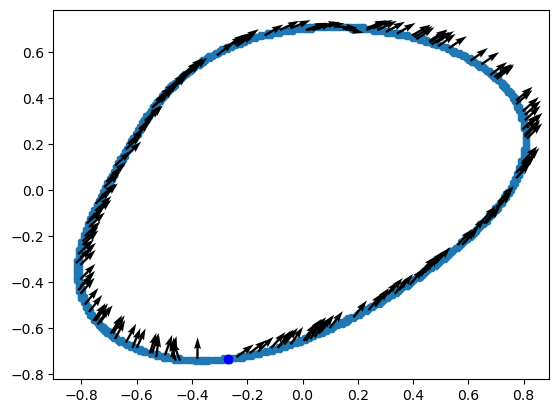

In [13]:
mask = np.abs(fX).flatten() < 0.01 #np.inf
submask = np.logical_and( mask, np.random.uniform( 0,1, len(mask)) < 0.1 ).flatten()
plt.scatter(X[:,0][mask], X[:,1][mask], marker='.' )
plt.quiver( X[:,0][submask], X[:,1][submask], -nu[submask], -nv[submask]  )
plt.scatter(X[:,0][u0.flatten() > 0.9], X[:,1][u0.flatten() > 0.9], c=u0.flatten()[u0.flatten() > 0.9], cmap='bwr')

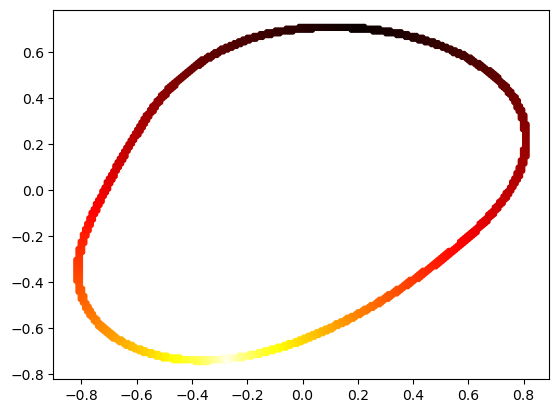

In [14]:
plt.scatter(X[:,0][mask], X[:,1][mask], c=np.sqrt( -4 * t * np.log(ut[mask]) ), marker='.', cmap='hot_r' )

/tmp/ipykernel_3473597/2275049027.py:8: RuntimeWarning: divide by zero encountered in log
  varadhan = np.sqrt( -4 * t * np.log(ut) )


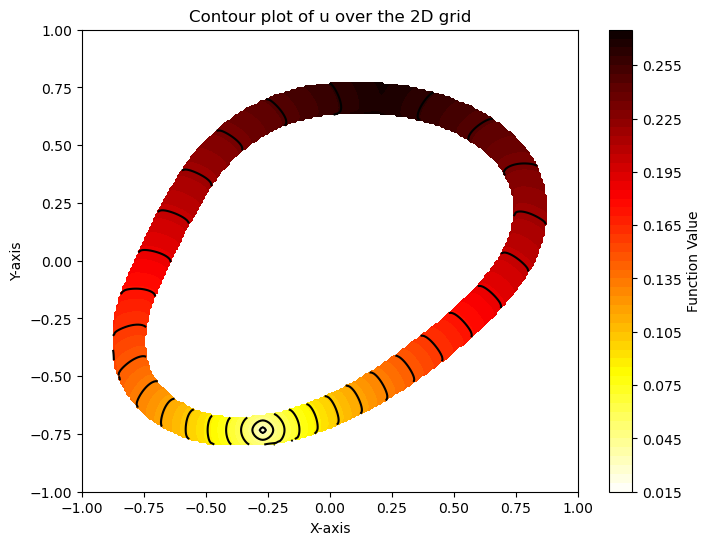

In [15]:
x_unique = np.unique(X[:, 0])
y_unique = np.unique(X[:, 1])
nx, ny = len(x_unique), len(y_unique)

# Reshape u to fit the grid
#logs = np.ones_like(ut) * 3
#np.log(ut, where= np.isclose(ut, np.zeros_like(ut)), out=logs )
varadhan = np.sqrt( -4 * t * np.log(ut) )
u_grid = varadhan.reshape(ny, nx)

num_levels = 20  # You can adjust the number of levels as desired
#u_min, u_max = varadhan.min(), varadhan.max()
u_min, u_max =0, 0.275
levels = np.linspace(u_min, u_max, num_levels)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(x_unique, y_unique, u_grid, levels=50, cmap='hot_r')  # Filled contour
plt.colorbar(label='Function Value')
plt.contour(x_unique, y_unique, u_grid, colors='black', levels=levels)  # Contour lines
#plt.scatter(X[:,0][mask], X[:,1][mask], marker='.' )
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Contour plot of u over the 2D grid')
plt.show()


En el paper para lidiar con esto, resuelven la ecuacion de Poisson: $\Delta \varphi = \nabla \cdot X$

En discreto seria: $ L \varphi = Div X $

In [29]:
mask = np.abs(fX).flatten() < np.inf
#L= gridLaplaceBeltrami(N, dfX, LfX, mask, boundary='neumann')
L= gridLaplacian(N, mask, boundary='dirichlet')
Gx, Gy = gridDxMasked(N, mask ), gridDyMasked(N, mask)

nx = np.nan_to_num( -nu )
ny = np.nan_to_num( -nv )

phi = sparse.linalg.spsolve( L , Gx @ nx + Gy @ ny)

In [30]:
phi

array([-2.47610249e-05, -4.95035899e-05, -7.42091800e-05, ...,
        7.71536456e-05,  5.14571802e-05,  2.57350136e-05])

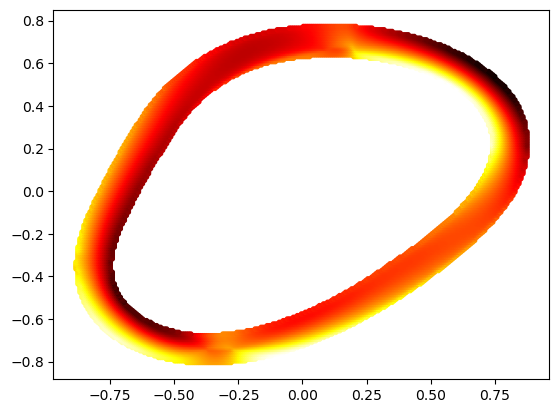

In [31]:
mask = np.abs(fX).flatten() < 0.07
plt.scatter(X[:,0][mask], X[:,1][mask], c=phi[mask], marker='.', cmap='hot_r' )

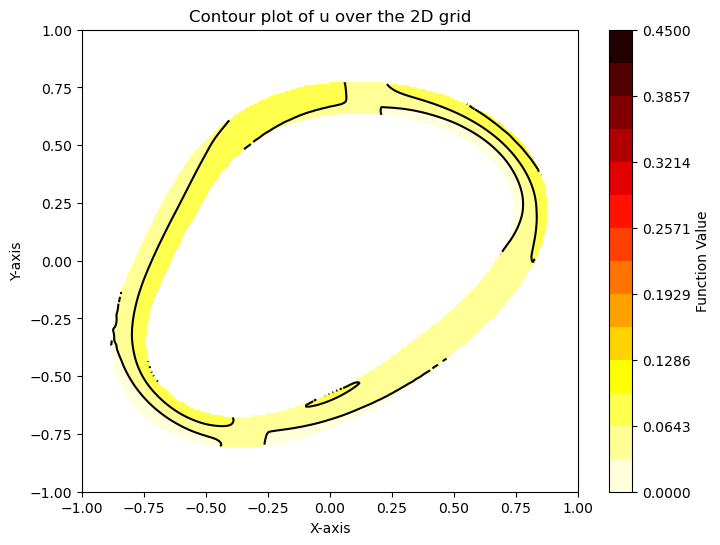

In [32]:
x_unique = np.unique(X[:, 0])
y_unique = np.unique(X[:, 1])
nx, ny = len(x_unique), len(y_unique)

# Reshape u to fit the grid
u_grid = phi.reshape(ny, nx) - phi.min()
mask = np.abs(fX).flatten() > 0.07
u_masked = np.ma.masked_where( mask.reshape(N,N), u_grid)

num_levels = 15  # You can adjust the number of levels as desired
#u_min, u_max = varadhan.min(), varadhan.max()
u_min, u_max =0, 0.45
levels = np.linspace(u_min, u_max, num_levels)

# Plotting
plt.figure(figsize=(8, 6))
plt.contourf(x_unique, y_unique, u_masked, levels=levels, cmap='hot_r')  # Filled contour
plt.colorbar(label='Function Value')
plt.contour(x_unique, y_unique, u_masked, colors='black', levels=levels)  # Contour lines
#plt.scatter(X[:,0][mask], X[:,1][mask], marker='.' )
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Contour plot of u over the 2D grid')
plt.show()